# Discrete Choice Analysis: micro-econometrics and machine learning approaches

## `Lab session 2A`<br> `Behavioural insights: Hybrid ANN-MNL models`

**Delft University of Technology**<br>
**Q2 2022**<br>
**Instructor:** Sander van Cranenburgh <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

# `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are put to practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

# `Workspace set-up`
**Option 1: Google Colab**<br>
Uncomment the following cell if you are running this notebook on Colab

In [126]:
#!git clone https://github.com/TPM34A/ML_approaches_for_discrete_choice_analysis
#!pip install -r ML_approaches_for_discrete_choice_analysis/requirements.txt
#!mv "/content/ML_approaches_for_discrete_choice_analysis/Lab sessions/data" /content/data

**Option 2: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment, to install all dependencies on your Python version.

In [127]:
#!pip install -r requirements.txt

# `Application: Swiss mode choice` <br>
In this lab session we will continue analysing mode choices behaviour. However, now our are aim is to obtain behavioural insights from ML models. <br>
To do so, in this lab session you will (1) develop a hybrid ANN-MNL model, and use (2) SHAP values <br>

**Learning objectives**. After completing the following exercises you will be able to: <br>
1. **Estimate a  RUM-MNL model using PandasBiogeme<br>**
2. **Train hybrid-ANN-MNL models and extract behavioural insights, such as VTTs, from them<br>**
3. **Discuss the strength and weaknesses of using fully transparant RUM models, hybrid-models and fully opaque ANNs <br>**
4. Use SHAP values to obtain behavioural insights from an otherwise opaque ML model (`lab session 2B`)<br>
5. Use SHAP values to improve the model specification of a theory-driven RUM-MNL discrete choice model (`lab session 2B`)<br>

#### `Organisation`
This lab session comprises **`6`** parts:
1. Preparing your data set
2. Estimating a RUM-MNL discrete choice model using PandasBiogeme (to benchmark)
3. The hybrid ANN-MNL model
4. Evaluating and comparing performances of trained models

and comprises **`4`** exercises.

In [128]:
# Import required Python packages and modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd

# Biogeme
import biogeme.biogeme as bio
import biogeme.database as db
import biogeme.optimization as opt
import biogeme.messaging as msg
from biogeme import models
from biogeme.expressions import Beta

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Tensorflow
from tensorflow import keras
from keras import backend as K
from keras.layers import Input, Dense, Activation
from keras.layers import Conv2D, Add, Reshape
from keras.models import Model
from keras.utils.np_utils import to_categorical   


### **1. Preparing your data set** <br>

#### **Load the data**

In [129]:
# Get the current working directory
datafile_path = os.path.join(getcwd(),'data','')
print(datafile_path)

\\svm112.tudelft.net\staff_homes_c\sandervancranenburgh\Desktop folders\ANN\PY\Admin_2022\lab sessions\lab_ex02\data\


In [130]:
# Load mode choice data into a pandas DataFrame
df = pd.read_csv(datafile_path + 'swissmetro.dat',sep = '\t')

#### **Clean the data**

In [131]:
# Data cleaning

# Only keep data for purposes 'Commute" and "Business"
df.drop(df[(df.PURPOSE != 1) & (df.PURPOSE != 3)].index, inplace=True) 

# Drop rows with unknown choices (CHOICE == 0)
df.drop(df[df.CHOICE == 0].index, inplace=True) 

# In case of reamining missing values, replace them with 0
df.fillna(0, inplace = True) 

#### **Correct cost for concession card holders**
When travellers have a concession card, the marginal cost for a trip is zero. That is, one extra trip does not cost anything extra. <br>
Therefore, we 'manually' set the TRAIN and SM cost to zero.

In [132]:
# When GA equals 0, the traveller does not have a concession card; when GA equals 1, the traveller has a concession card. 
df['SM_CO'] = df.SM_CO * (df.GA == 0)             
df['TRAIN_CO'] = df.TRAIN_CO * (df.GA == 0)    

### **2. Estimating a RUM-MNL discrete choice model using PandasBiogeme (to benchmark)**
To compare the performance and outputs of the hybrid ANN-MNL that we will build next, we first estimate our benchmark model: the canonical RUM-MNL.<br>


In the RUM-MNL model utility is assumed to be linear additive-utility: 

$ V_{in} = ASC_{i} + \sum_{m}\beta_m x_{imn}$

With this model we estimate the ASCs and marginal utilities (i.e. betas) for: 

1. Travel Time [min] 
2. Travel cost [chf] (Swiss franc)

In [133]:
# Convert pandas df in biogeme database
database = db.Database('swissmetro data', df)

# The following statement allows you to use the names of the variable as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 1)
ASC_SM = Beta('ASC_SM', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Set cost to zero for concession card holders
SM_COST = SM_CO * (GA == 0)             
TRAIN_COST = TRAIN_CO * (GA == 0)       

# Rescale attributes for numerical stability
TRAIN_TT_SCALED   = TRAIN_TT / 100
TRAIN_COST_SCALED = TRAIN_COST / 100
SM_TT_SCALED      = SM_TT / 100
SM_COST_SCALED    = SM_COST / 100
CAR_TT_SCALED     = CAR_TT / 100
CAR_CO_SCALED     = CAR_CO / 100

# Utility functions
V1 = ASC_TRAIN + B_TIME * TRAIN_TT_SCALED + B_COST * TRAIN_COST_SCALED
V2 = ASC_SM    + B_TIME * SM_TT_SCALED    + B_COST * SM_COST_SCALED
V3 = ASC_CAR   + B_TIME * CAR_TT_SCALED   + B_COST * CAR_CO_SCALED

# Associate utility functions with the numbering of alternatives in df.CHOICE
V = {1: V1, 2: V2, 3: V3}

# Associate the availability conditions with the alternatives
AV = {1: TRAIN_AV, 2: SM_AV, 3: CAR_AV}

# Definition of the model. This is the contribution of each observation to the log likelihood function.
logprob = models.loglogit(V, AV, CHOICE)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'RUM-MNL'
biogeme.generatePickle = False
biogeme.generateHtml = False

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(AV)

# Estimate the parameters
results = biogeme.estimate()

# Report the results in a pandas table
print('Estimated parameters')
print('----------')
print(results.getEstimatedParameters()[['Value','Std err','t-test','p-value']])

# Perform a 'simulation' to compute the choice probabilities based on the estimated model (for later use)
simulate = {
    'Prob_TRAIN':      models.logit(V, AV, 1),
    'Prob_SM':         models.logit(V, AV, 2),
    'Prob_CAR':        models.logit(V, AV, 3)}

# Create the biogeme simulation object
biosim = bio.BIOGEME(database, simulate)
prob_mnl = biosim.simulate(results.getBetaValues()).to_numpy()


Estimated parameters
----------
            Value   Std err     t-test  p-value
ASC_CAR  0.546555  0.046115  11.851988      0.0
ASC_SM   0.701187  0.054874  12.778150      0.0
B_COST  -1.083790  0.051830 -20.910405      0.0
B_TIME  -1.277859  0.056883 -22.464561      0.0


#### **Show the model performance statistics and the  Value of Travel Time (VTT)**

In [134]:
# Show the model performance
print(results.shortSummary())

# Compute and print the cross entropy
cross_entropy =  -(results.getGeneralStatistics()['Final log likelihood'][0])/(results.getGeneralStatistics()['Sample size'][0])
print(f'Cross entropy:\t\t\t {cross_entropy:.3f}')

# Compute the Value-of-Travel Time: (60*beta_TIME/beta_COST)
betas = results.getBetaValues()
VTT   = 60*betas['B_TIME']/(betas['B_COST'])
print(f'\nThe Value-of-Travel-Time = {VTT:.3f} chf/hr.')

Results for model RUM-MNL
Nbr of parameters:		4
Sample size:			6768
Excluded data:			0
Null log likelihood:		-6964.663
Final log likelihood:		-5331.252
Likelihood ratio test (null):		3266.822
Rho square (null):			0.235
Rho bar square (null):			0.234
Akaike Information Criterion:	10670.5
Bayesian Information Criterion:	10697.78

Cross entropy:			 0.788

The Value-of-Travel-Time = 70.744 chf/hr.


### ``Exercise 1: Interpreting the Value-of-Travel Time``
`A` Interpret the estimation results of the MNL model in terms of the sing and sizes of the parameters<br>
`B` The most recent Swiss value of travel time study finds a VTT of 27 ch/hr for car, and 14 chf/hr for Public Transport. <br>
Could you think of reasons why the estimate found here is so much larger?<br>
`C` Compute the Willingness to pay to go by SM instead of TRAIN, all esle being equal, using the formula: WtP_SM = -(ASC_SM-ASC_TRAIN) / B_COST<br>

In [135]:
# ANSWERS
# A The parameters have the expected signs. B_TIME and B_COST are negative. The ASCs show that - all else being equal - SM and CAR are preferred over TRAIN.
# Furthermore, we see that all parameter estimates are highly significant.
# B Stated choice experiments can suffer from hypothetical bias for several reasons:
#   - people do not have to put their money where their mouth is in such experiments.
#   - people may respond strategically (e.g. hoping the SM would be build if they reveal they would often use it, will in reality they would not use it so often)

In [136]:
WtP_SM = -betas['ASC_SM']/(betas['B_COST']/100)
print(f'The willingness to pay to use SM instead of TRAIN (all else being equal) = \t {WtP_SM:.2f} chf')

The willingness to pay to use SM instead of TRAIN (all else being equal) = 	 64.70 chf


### **3. The hybrid ANN-MNL model**
Next, we are going to train the hybrid ANN-MNL model. In this lab session we aim to obtain a **Value-of-Time** using a hybrid ANN-MNL model.<br>
To do so, we take the following steps:<br>
* Define lists of features for the MNL and ANN parts
* Set the global variables and hyperparameters
* Create the hybrid ANN-MNL object
* Compile the model
* Prepare the data for training the hybrid ANN-MNL model
* Train the model

#### **Define lists of the features for the MNL and ANN parts**
We place the features of behavioural interest: in casu, travel cost and travel time, in the *MNL part of the model*. <br>
We place the remaining features in the *ANN part of the model*

In [137]:
features_mnl = ['TRAIN_TT','TRAIN_CO','SM_TT','SM_CO','CAR_TT','CAR_CO']
features_ann = ['PURPOSE', 'FIRST','TICKET', 'WHO', 'LUGGAGE', 'AGE','MALE', 'GA','INCOME', 'ORIGIN','DEST','TRAIN_HE','SM_HE','SM_SEATS','TRAIN_AV','SM_AV','CAR_AV']

#### **Set the global variables and hyperparameters**

In [138]:
# Global variables (do not change)
OBS = int(len(df))                      # Number of observations
NALT = int(3)                           # Number of alternatives in the data set.
no_X_MNL = int(len(features_mnl)/NALT)  # Number of attributes with behavioural interest (-->MNL model part).  In this example we are particularly interested in the VTT--> Cost & Tume
no_X_ANN = int(len(features_ann))       # Number of features without behavioural interest (-->ANN model part). 

# Hyperparameters
num_nodes = 10                          # Number of nodes in hidden layer(s). Again we use 2 hidden layers with *num_nodes* nodes each
alpha = 0.00001                         # L2 regularisation
nEpoch = 50                             # Max number epochs for training

#### **Create the hybrid ANN-MNL object**
We build the hybrid ANN-MNL models in a number of steps. That is, we create the layers separately and connect them to one another.<br>
Specifically, next we create:<br>
- MNL part
- ANN part
- A layer where the utilities of the MNL and ANN parts come together
- Output layer

**MNL part**

To create the MNL part, we use a convolution layer. 

In [139]:
# Create the input layer for MNL part
X_MNL = Input((no_X_MNL, NALT,1), name = 'Features2MNL')

# Create the utility layer for the MNL part.
# kernel_size = [no_X_MNL,1] defines the height and width of the convolution kernel
# strides = (2,1) defines the stride
# padding = 'valid' means that NO padding is used (not discussed in class)
V_MNL = Conv2D(filters = 1, kernel_size = [no_X_MNL,1], strides = (2,1), padding = 'valid', name = 'MNL_layer', use_bias = False, trainable = True)(X_MNL)

**ANN part**

To create the ANN part, we use a dense layer. in tensorflow dense layers refer to fully connected MLP layers

In [140]:
# Create the input layer for the ANN part
X_ANN = Input((no_X_ANN), name ='Features2ANN')

# Create the hidden layers for the ANN part
reg = keras.regularizers.L2(alpha)  # defines regularisation settings. Here we use L2 regularisation. 
layer1_ANN = Dense(units = num_nodes, name = "ANN_HiddenLayer1", use_bias = True, kernel_regularizer = reg)(X_ANN)      
layer2_ANN = Dense(units = num_nodes, name = "ANN_HiddenLayer2", use_bias = True, kernel_regularizer = reg)(layer1_ANN)

# Create the  
V_ANN = Dense(units = NALT, name = "V_ANN", use_bias = True)(layer2_ANN) 

**Part where the MNL and ANN parts come together**

In [141]:
# Reshape the tensors to [1 X NALT]
V_MNL = Reshape([NALT], name = 'Flatten_MNL')(V_MNL)
V_ANN = Reshape([NALT], name = 'Flatten_ANN')(V_ANN) 

# Create a layer that simply sums the utilities of the MNL and ANN parts
V_MNL_ANN = Add(name = "sum_V_MNL_V_ANN")([V_MNL,V_ANN])

**Output layer**

In [142]:
# Use a logit output layer with V_MNL_ANN as input
logitProb = Activation('softmax', name = 'Probability')(V_MNL_ANN)

# Create the model, by putting everything together
model = Model(inputs = [X_MNL, X_ANN], outputs = logitProb)

Once the model is built, we inspect the model object, using model.summary(). For example, we look at whether the layers have the expected shapes and number of weights (Param #)

In [143]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features2ANN (InputLayer)      [(None, 17)]         0           []                               
                                                                                                  
 ANN_HiddenLayer1 (Dense)       (None, 10)           180         ['Features2ANN[0][0]']           
                                                                                                  
 Features2MNL (InputLayer)      [(None, 2, 3, 1)]    0           []                               
                                                                                                  
 ANN_HiddenLayer2 (Dense)       (None, 10)           110         ['ANN_HiddenLayer1[0][0]']       
                                                                                            

`@ Francisco, could you add a picture of hybrid network here?`

#### **Compile the model**
When we are satisfied with the created model structure, we compile the model.<br>
When we say we 'compile the model', we mean the model and the optimiser and wrapped together into a trainable object.

In [144]:
# Note that we use the Adam optimiser, with the shown settings
opt = keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(loss='categorical_crossentropy', metrics = ["accuracy"], optimizer = opt)

#### **Prepare the data for training the hybrid ANN-MNL model**
Preparing the model for training this model involves to:<br>
* Scale the features. This must be done separately for the the MNL and ANN parts.
* Create the train and test data sets

**Scale the features**<br>
Before training an ANN, we must scale the input features. However, since we want to compute VTTs the features of the MNL part cannot just be scaled by just any scaler. This would hamper the intepretation of the associated betas. Therefore, we must manually scale the features for the MNL part, while we can use the `sk-learn's` StandardScaler for the features for the ANN part. 

**Scale the features for MNL part**

In [145]:
# Create dataframe with features for MNL part
x_mnl = df[features_mnl]

# Manually scale all features by 100
scale = 100
x_mnl = np.divide(x_mnl,scale)

# Convert into a numpy array and reshape so the convolution layer can handle it.
# As convolution layers are designed for images, they take 4D tensors as inputs: Batch x Width x Height x RGB color channels
# In this case we use only 1 color channel (as if the image is in greyscale)
x_mnl = np.expand_dims(np.swapaxes(np.array(x_mnl.T).reshape((NALT,no_X_MNL,OBS)),axis1=2,axis2=0),3)
print('Shape of x_mnl', x_mnl.shape)

Shape of x_mnl (6768, 2, 3, 1)


**Scale the features for ANN part**

In [146]:
# Create dataframe with features for ANN part
x_ann = df[features_ann]

# Define the list of features that need to be scaled (excluding availabilities and the choice!)
features2scale = ['PURPOSE', 'FIRST','TICKET', 'WHO', 'LUGGAGE', 'AGE','MALE', 'INCOME', 'GA', 'ORIGIN','DEST','TRAIN_HE','SM_HE','SM_SEATS']

# Initiate scaler object & fit to features
scaler = StandardScaler()  
scaler.fit(x_ann.loc[:,features2scale])  

# Create new dataframe containing both the scaled features AND the (unscaled) ones. In particular, we do not want to scale the availabilities
x_ann = df[features_ann].copy()
x_ann.at[:, features2scale] = scaler.transform(df.loc[:,features2scale])
x_ann = np.array(x_ann)
print('Shape of x_ann',x_ann.shape)

Shape of x_ann (6768, 17)


**Create the train and test data sets**<br>
We use sk-learn's train_test_split function to obtain a train and test data set.

In [147]:
# Create a dataframe with the output target
Y = df['CHOICE']

# Unlike sk-learn, Tensorflow requires the targets to be dummmy coded
Y_cat = to_categorical(Y-1, num_classes = NALT)

In [148]:
# Split the data into a training and test part
# We split both the features for the MNL and ANN part
# We use the same random state. Thereby we make sure that the train and test for the MNL and ANN part contain the same observations
X_mnl_train, X_mnl_test, Y_train, Y_test = train_test_split(x_mnl, Y_cat, random_state = 1, test_size = 0.35)
X_ann_train, X_ann_test, Y_train, Y_test = train_test_split(x_ann, Y_cat, random_state = 1, test_size = 0.35)
print('Total number of observations in the data set = ', len(x_mnl))
print('Number of observations in the training set   = ', len(X_mnl_train))
print('Number of observations in the test set       = ', len(X_mnl_test))

Total number of observations in the data set =  6768
Number of observations in the training set   =  4399
Number of observations in the test set       =  2369


#### **Train the model**
Finally, we are ready to train the model! Let's see what happens.

In [149]:
# Train the model
history = model.fit([X_mnl_train, X_ann_train],Y_train, epochs = nEpoch, verbose = 1, validation_data = ([X_mnl_test, X_ann_test], Y_test))

Epoch 1/50
138/138 [==============================] - 1s 7ms/step - loss: 1.0035 - accuracy: 0.5376 - val_loss: 0.8526 - val_accuracy: 0.6066
Epoch 2/50
138/138 [==============================] - 1s 6ms/step - loss: 0.8246 - accuracy: 0.6188 - val_loss: 0.8070 - val_accuracy: 0.6256
Epoch 3/50
138/138 [==============================] - 1s 6ms/step - loss: 0.7999 - accuracy: 0.6326 - val_loss: 0.7941 - val_accuracy: 0.6328
Epoch 4/50
138/138 [==============================] - 1s 6ms/step - loss: 0.7883 - accuracy: 0.6367 - val_loss: 0.7846 - val_accuracy: 0.6374
Epoch 5/50
138/138 [==============================] - 1s 6ms/step - loss: 0.7816 - accuracy: 0.6440 - val_loss: 0.7795 - val_accuracy: 0.6399
Epoch 6/50
138/138 [==============================] - 1s 6ms/step - loss: 0.7768 - accuracy: 0.6483 - val_loss: 0.7741 - val_accuracy: 0.6387
Epoch 7/50
138/138 [==============================] - 1s 6ms/step - loss: 0.7726 - accuracy: 0.6481 - val_loss: 0.7740 - val_accuracy: 0.6454
Epoch 

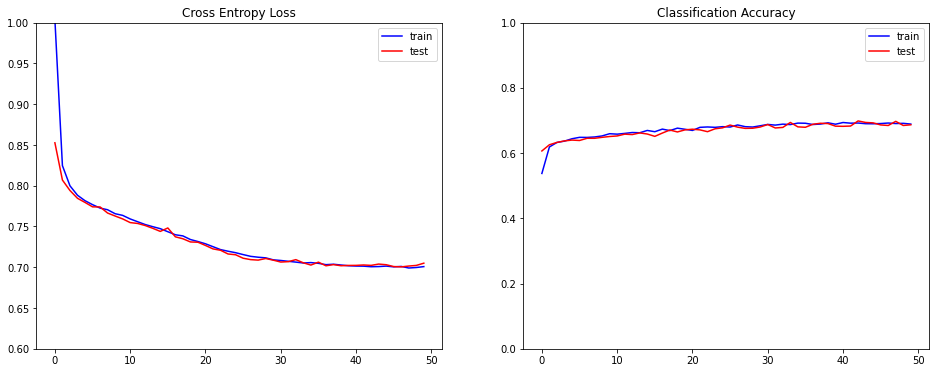

In [150]:
# Let's have a look at the training progress, in terms of loss and accuracy
# plot loss as a function of epochs
fig, axes =plt.subplots(1, 1, figsize=(16, 6))
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'],     color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'test')
plt.ylim(0.6,1)
plt.legend()

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'],     color = 'blue', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'test')
plt.ylim(0, 1)
plt.legend()

### `Exercise 2:`
`A` Training time of the hybrid ANN-MNL model using tensorflow is considerably slower than of the MLP (trained in sk-learn). Can you think of reasons why?<br>
`B` Performing a full-fletch hypertuning would be recommended, but is too time-comsuming for this lab session. Manually test the sensitivity to L2 regularisation (which turned out to be particularly important for the MLP). To do so, re-run this notebook with alpha is {1,0.1,0.00001}. Report you results. What L2 works best?<br><br>
`**After you are finished testing, set the L2 to the best value found.**`

In [151]:
# ANSWERS
# A There can be several reasons. 
# - First, the model has a more complex structure. Different routines need to be called. 
# - Second, Tensorflow is developed for heavy models, and GPU paralellisation. This model is not what it has been optimised for  
# alpha 0.00001:    0.70
# alpha 1           0.90
# alpha 0.1         0.80
# The smallest L2 regularisation yields the best generalisation performance.

### **4. Evaluating and comparing performances across trained models**<br>
Machine learning researchers usually evaluate the performance of a classification model using the cross-entropy, while choice modellers usually look at the Log-likelihood (LL) and the rho-square.<br>
As there is no standard function that outputs the evaluation metrics of both disciplines, below we (again) create our **own evaluation function**.

In [152]:
# We create an eavluation function that returns key evaluation metrics: LL, LL0, cross_entropy, rho_sq
# To compute these performance metrics, the function takes as inputs:
#   - the predicted probabilities (prob)
#   - the choices (Y)
#   - the availabilities (AV)
def eval_performance(prob,Y,AV):
    
    # Calculate the likelihood of the data given the model
    LL = np.sum(np.log(np.sum(prob*Y,axis=1)))

    # Calculate the Null-loglikelihood
    LL0 = np.sum(np.log(np.divide(1,np.sum(AV,axis=1))))

    # Calculate cross-entropy
    cross_entropy =  -LL/len(AV)
    
    # Calculate the rho_sq
    rho_sq = 1 -(LL/LL0)

    return LL, LL0, cross_entropy, rho_sq

Evaluate the performance of the hybrid model

In [157]:
# Evaluate performance on the training and test data sets of the hybird ANN-MNL model
eval_train = eval_performance(model.predict([X_mnl_train, X_ann_train]),Y_train, X_ann_train[:,[-3,-2,-1]])
eval_test  = eval_performance(model.predict([X_mnl_test , X_ann_test ]),Y_test , X_ann_test[:,[-3,-2,-1]])

# Print the results
pd.options.display.float_format = '{:,.2f}'.format
results = pd.DataFrame({'data set':     ['Train','Test'],
                        'LL':           [eval_train[0], eval_test[0]],
                        'LL0':          [eval_train[1], eval_test[1]],
                        'cross_entropy':[eval_train[2], eval_test[2]],
                        'rho_sq':       [eval_train[3], eval_test[3]]})

print('Model performance of the hybrid ANN-MNL model')
print(results.T)

Model performance of the hybrid ANN-MNL model
                      0         1
data set          Train      Test
LL            -3,060.24 -1,669.53
LL0           -4,535.18 -2,429.48
cross_entropy      0.70      0.70
rho_sq             0.33      0.31


For comparison, evaluate the performance of the RUM-MNL model

In [158]:
# For comparison, we also evaluate performance on the training and test data sets of the linear-additive RUM model
eval_mnl = eval_performance(prob_mnl,np.transpose([Y ==1,Y ==2,Y ==3]), df[['TRAIN_AV','SM_AV','CAR_AV']])

# Print the results
pd.options.display.float_format = '{:,.2f}'.format
results = pd.DataFrame({'data set':     ['All data'],
                        'LL':           [eval_mnl[0]],
                        'LL0':          [eval_mnl[1]],
                        'cross_entropy':[eval_mnl[2]],
                        'rho_sq':       [eval_mnl[3]]})

print('Model performance of the RUM-MNL model')
print(results.T)

Model performance of the RUM-MNL model
                      0
data set       All data
LL            -5,331.25
LL0           -6,964.66
cross_entropy      0.79
rho_sq             0.23


**Value-of-Time**<br>
Our objective in this lab session is to compute the Value-of-Time, using the hybrid ANN-MNL model. <br>
Assessing the VTT is also part of the model evaluation. After all, a model that fits well, but throws an unrealistic VTT is not useful.<br>
To do so, we access the learned weights. Since the MNL part is linear and additive, we can compute the VTT simply by taking the ratio of the Beta for time over the Beta for cost.

In [154]:
# Get the weights of the MNL_layer
betas_layer = model.get_layer(name = 'MNL_layer')
betas = betas_layer.get_weights()
beta_TT = np.squeeze((betas[0][0]))
beta_TC = np.squeeze((betas[0][1]))
print(f'Beta_TT = \t{beta_TT:.3f}') 
print(f'Beta_TC = \t{beta_TC:.3f})')

# Compute VTT
VTT = 60*(beta_TT/beta_TC)
print(f'The Value-of-Time is {VTT:.2f} Swiss franc per hour')

Beta_TT = 	-1.081
Beta_TC = 	-1.206)
The Value-of-Time is 53.76 Swiss franc per hour


Text(0.5, 1.0, 'Hybrid ANN-MNL - normalised')

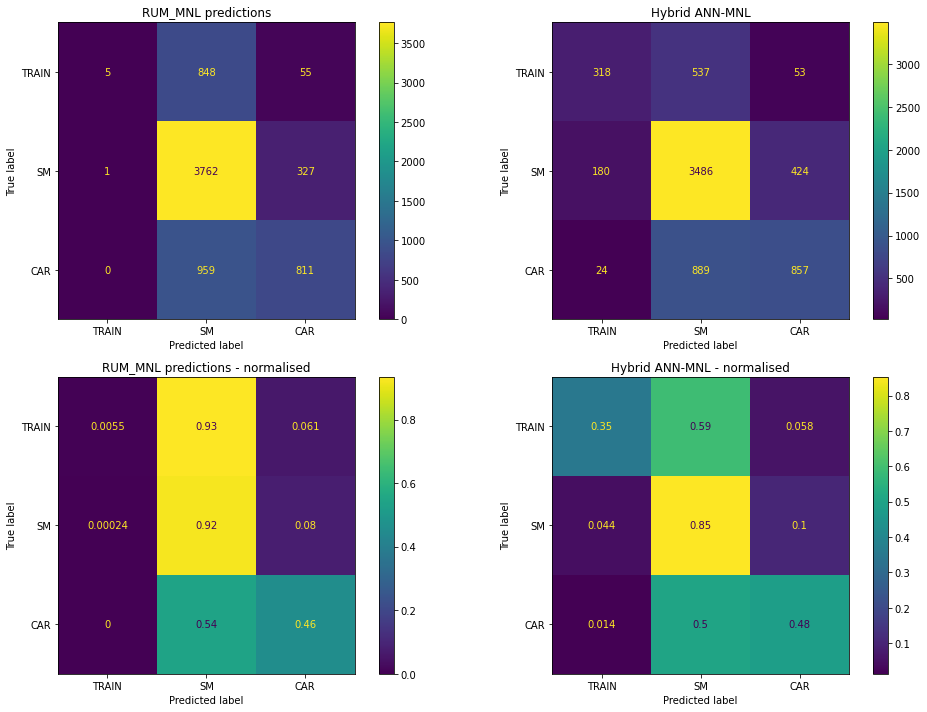

In [155]:
# Predict the choices (hits) using the MNL and hybrid-ANN-MNL models
Y_pred_mnl = np.argmax(prob_mnl, axis =1)+1 # <-- Argument for finding the column with the highest predicted probability for the MNL model
Y_pred_hybrid = np.expand_dims(np.argmax(model.predict([x_mnl, x_ann]),axis = 1),axis =1)+1

# Show the confusion matrices to asses difference between the predictions of the MNL and hybrid ANN-MNL models
ylabels = ['TRAIN','SM','CAR']
fig, ax = plt.subplots(2,2,figsize = (14,10))
fig.set_tight_layout(True)

# Dsiplay confusion matrices, non-normalised and normalised
cm1 = ConfusionMatrixDisplay.from_predictions(y_true=Y,y_pred=Y_pred_mnl,    display_labels = ylabels, normalize=None,  ax=ax[(0,0)])
cm2 = ConfusionMatrixDisplay.from_predictions(y_true=Y,y_pred=Y_pred_mnl,    display_labels = ylabels, normalize='true',ax=ax[(1,0)])
cm3 = ConfusionMatrixDisplay.from_predictions(y_true=Y,y_pred=Y_pred_hybrid, display_labels = ylabels, normalize=None,  ax=ax[(0,1)])
cm4 = ConfusionMatrixDisplay.from_predictions(y_true=Y,y_pred=Y_pred_hybrid, display_labels = ylabels, normalize='true',ax=ax[(1,1)])

# Add titles to confusion matrices
cm1.ax_.set_title('RUM_MNL predictions')
cm2.ax_.set_title('RUM_MNL predictions - normalised')
cm3.ax_.set_title('Hybrid ANN-MNL')
cm4.ax_.set_title('Hybrid ANN-MNL - normalised')

### `Exercise 3: Model performance evaluation and comparison`<br>
`A` Interpret and explain the difference in the model cross entropy performance of the RUM-MNL, Hybrid ANN-MNL, and ANN (previous lab session)<br>
`B` Show the Precision, Recall, and F1 score for the hybrid ANN-MNL and for the RUM-MNL, using `sk-learn's` `classification_report` function and interpret the results<br>

In [156]:
# To calculate the precision, recal and f1 score we conveniently use sk-learn's 'classification_report' functionality
print('Classification report forthe RUM-MNL model\n',
    classification_report(Y,Y_pred_mnl, target_names= ylabels))
print('\nClassification report for hybrid ANN-MNL model\n',
    classification_report(Y,Y_pred_hybrid, target_names= ylabels))

Classification report forthe RUM-MNL model
               precision    recall  f1-score   support

       TRAIN       0.83      0.01      0.01       908
          SM       0.68      0.92      0.78      4090
         CAR       0.68      0.46      0.55      1770

    accuracy                           0.68      6768
   macro avg       0.73      0.46      0.45      6768
weighted avg       0.70      0.68      0.62      6768


Classification report for hybrid ANN-MNL model
               precision    recall  f1-score   support

       TRAIN       0.61      0.35      0.44       908
          SM       0.71      0.85      0.77      4090
         CAR       0.64      0.48      0.55      1770

    accuracy                           0.69      6768
   macro avg       0.65      0.56      0.59      6768
weighted avg       0.68      0.69      0.67      6768



#### `Exercise 4: Hand-engineering for interactions with cost needed?`
In part 1 ('Preparing your data') we set the cost for TRAIN and SM to zero for concession card holders (GA == 1). <br>
`A` Re-run your whole notebook, but without setting the cost for TRAIN and SM to zero. <br>
Look at the model performance (e.g. cross entropy) as well as the VTT. What catches the eye?<br>
`B` Could you think of a reason that explains the difference between the run with and without having set the cost to zero for TRAIN and SM?<br>